<a href="https://colab.research.google.com/github/kimayeon-hub/DeepLearning1/blob/main/Week5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제: House Prices 예측 모델 변경하기
- 최종 변경 모델의 결과
  - 변경한 하이퍼 파라미터
    - `epoch`: 50 -> 60
    - `learning_rate`: 0.001 -> 0.0005
  - 예측률이 0.24659 -> **0.36208**로 증가함

## 기본 모델 코드

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### 데이터 읽기

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### NaN 값 처리

In [3]:
# NaN 비율 확인 함수
def check_nan_ratio(df):
    return df.isna().mean() * 100

# 결측치 비율이 5% 이상인 컬럼 제거 함수
def drop_high_nan_columns(train_df, test_df, threshold=5.0):
    train_nan_ratio = check_nan_ratio(train_df)
    cols_to_drop = train_nan_ratio[train_nan_ratio >= threshold].index.tolist()     #5% 이상인 컬럼 추출
    train_df_cleaned = train_df.drop(columns=cols_to_drop)
    test_df_cleaned = test_df.drop(columns=cols_to_drop, errors='ignore')
    return train_df_cleaned, test_df_cleaned, cols_to_drop

# 결측치 제거
train_df_cleaned, test_df_cleaned, removed_columns = drop_high_nan_columns(train_df, test_df)

# NaN이 포함된 행 제거
train_df_cleaned = train_df_cleaned.dropna()

# test_df_cleaned에서 NaN이 존재하는 컬럼 찾기
nan_cols_in_test = test_df_cleaned.columns[test_df_cleaned.isna().any()].tolist()

# 해당 컬럼들을 두 데이터셋에서 제거
train_df_cleaned = train_df_cleaned.drop(columns=nan_cols_in_test, errors='ignore')
test_df_cleaned = test_df_cleaned.drop(columns=nan_cols_in_test, errors='ignore')

### 필요없는 컬럼 제거

In [4]:
# train_df_cleaned에서 'Id' 컬럼 제거
if 'Id' in train_df_cleaned.columns:
    train_df_cleaned = train_df_cleaned.drop(columns=['Id'])

### 수치화

In [5]:
# 0. test 데이터에서 Id 컬럼 제거 및 저장
if 'Id' in test_df_cleaned.columns:
  id_column = test_df_cleaned['Id'].to_numpy()
  test_df_cleaned = test_df_cleaned.drop(columns=['Id'])

# 1. train 데이터에서 숫자가 아닌 컬럼 찾기 (SalePrice 제외)
non_numeric_cols = train_df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
if 'SalePrice' in non_numeric_cols:
  non_numeric_cols.remove('SalePrice')

# 2. train 데이터에서 원 핫 인코딩 후 컬럼 수 계산
total_columns = 0
encoding_info = {}  # 각 컬럼별 인코디 정보를 저장할 딕셔너리

for col in train_df_cleaned.columns:
  if col == 'SalePrice':
    total_columns += 1  # SalePrice는 숫자형으로 그대로 추가
  elif col in non_numeric_cols:
    unique_values = train_df_cleaned[col].unique()
    encoding_info[col] = unique_values  # 원 핫 인코딩 값 기억
    total_columns += len(unique_values)
  else:
    total_columns += 1

# 3. 빈 넘파이 배열 생성
num_rows_train = train_df_cleaned.shape[0]
num_rows_test = train_df_cleaned.shape[0]
train_array = np.zeros((num_rows_train, total_columns), dtype=np.float32)
test_array = np.zeros((num_rows_test, total_columns), dtype=np.float32)

# 4. 학습 데이터와 테스트 데이터를 같은 기준으로 변환
def one_hot_encode_value(value, unique_values):
  # 원 핫 인코딩 벡터를 반환
  one_hot_vector = np.zeros(len(unique_values), dtype=np.float32)
  if value in unique_values:
    index = np.where(unique_values == value)[0][0]
    one_hot_vector[index] = 1.0
  return one_hot_vector

# 변환 함수
def transform_dataframe(df, encoding_info, is_train=True):
  current_col = 0
  num_cols = total_columns if is_train else total_columns - 1
  transformed_array = np.zeros((df.shape[0], num_cols), dtype=np.float32)

  for col in train_df_cleaned.columns:
    if col == 'SalePrice' and not is_train:
      continue  # 테스트 데이터에 SalePrice는 없음

    if col in non_numeric_cols:
      unique_values = encoding_info[col]
      for i, value in enumerate(df[col]):
        one_hot_vector = one_hot_encode_value(value, unique_values)
        transformed_array[i, current_col:current_col + len(unique_values)] = one_hot_vector
      current_col += len(unique_values)
    else:
      transformed_array[:, current_col] = df[col].to_numpy()
      current_col += 1

  return transformed_array

# 데이터 변환
train_array = transform_dataframe(train_df_cleaned, encoding_info, is_train=True)
test_array = transform_dataframe(test_df_cleaned, encoding_info, is_train=False)

### 데이터셋 분리

In [6]:
train_y = train_array[:, -1]
train_x = train_array[:, :-1] # 마지막 컬럼을 제외한 나머지
test_x = test_array

### 정규화

In [7]:
# train_x의 최대값과 최소값 계산
train_x_min = np.min(train_x, axis=0)
train_x_max = np.max(train_x, axis=0)

# train_y의 최대값과 최소값 계산
train_y_min = np.min(train_y)
train_y_max = np.max(train_y)

# 정규화 함수
def normalize(data, min_val, max_val):
  return (data - min_val) / (max_val - min_val)

# 정규화
train_x = normalize(train_x, train_x_min, train_x_max)
train_y = (train_y - train_y_min) / (train_y_max - train_y_min)

test_x = normalize(test_x, train_x_min, train_x_max)

### 모델 만들기

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0326 - mae: 0.1377 - val_loss: 0.0096 - val_mae: 0.0716
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mae: 0.0582 - val_loss: 0.0067 - val_mae: 0.0588
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0444 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - mae: 0.0394 - val_loss: 0.0058 - val_mae: 0.0535
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0344 - val_loss: 0.0057 - val_mae: 0.0523
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mae: 0.0324 - val_loss: 0.0055 - val_mae: 0.0510
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0313 - val_loss: 0.0055 - val_mae: 0.0516
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0052 - val_mae: 0.0490
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0269 - va

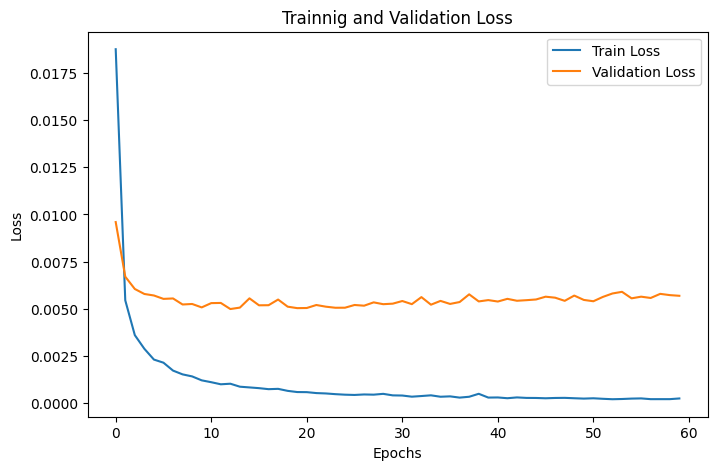

In [41]:
# MLP 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_x.shape[1],)), # 입력층
    Dense(64, activation='relu'), # 은닉층
    Dense(1, activation='linear') # 출력층 (회귀 무네라면 'linear', 분류라면 'sigmoid' 또는 'softmax)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# 모델 학습 (검증 데이터 비율: 20%)
history = model.fit(train_x, train_y, epochs=60, batch_size=32, validation_split=0.2, verbose=1)

# 모델 평가
loss, mae = model.evaluate(train_x, train_y)
print(f"\n훈련 손실: {loss:.4f}, 훈련 MAE: {mae:.4f}")

# 학습 및 검증 손실 시각화
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Trainnig and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 예측

In [42]:
# 테스트 데이터 예측
predictions = model.predict(test_x)
print("\n테스트 데이터 예측 완료.")

# 예측된 값을 원래 스케일로 변환하는 함수
def inverse_normalize(data, min_val, max_val):
  return data * (max_val - min_val) + min_val

# 예측값을 원래 스케일로 변환
predictions_original = inverse_normalize(predictions, train_y_min, train_y_max)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

테스트 데이터 예측 완료.


### 예측값을 제출 형태로 변환 및 파일로 저장

In [43]:
# sample_submission.csv 파일 읽기
sample_submission = pd.read_csv('sample_submission.csv')

# SalePrice 컬럼의 데이터를 predictions_original로 대체하기
sample_submission['SalePrice'] = predictions_original.flatten()

# 새로운 이름으로 저장
sample_submission.to_csv('output7.csv', index=False)

In [44]:
sample_submission

,Id,SalePrice
0,1461,149437.125000
1,1462,138591.187500
2,1463,180227.078125
3,1464,196563.875000
4,1465,269244.562500
...,...,...
1454,2915,62686.671875
1455,2916,125974.812500
1456,2917,166358.234375
1457,2918,99516.109375


## 하이퍼 파라미터 변경하기

### answer2
- batch_size: 32 -> 16
- epoch: 50 -> 100
- layer: 3층 -> 5층


> 0.24659 -> 0.15866으로 감소

### answer3
- `answer2`
  - 60 epoch 이후부터 validation loss가 증가하고 있음
  - epoch를 50으로 돌려보자

<br>

- batch_size: 16
- layer: 5층

> 0.15866 -> 0.18425으로 조금 증가 <br>
> 하지만 첫 모델보다 낮음

### answer4
- batch_size: 16
- epoch: 100
- layer: 5층
- learning_rate: 0.0005

### answer5
- `answer4`
  - validation loss가 90 epoch 쯤에서 약간 증가함 <br>
  - epoch을 80으로 줄이자

<br>

- batch_size: 16
- epoch: 80
- layer: 5층
- learning_rate: 0.0005

### answer6
- `answer5`
  - validation loss가 60 쯤에서 가장 낮음 <br>
  - epoch을 60으로 줄이자

<br>

- epoch: 60
- layer: 5층
- learning_rate: 0.0005

> 0.18784 -> 0.19166으로 증가 <br>
> 하지만 첫 모델보다 낮음

### answer7
- `answer2~6`
  - layer를 3층에서 5층으로 늘렸는데 결과가 좋지 않음
  - layer를 다시 3층으로 해서 시도해보자

<br>

- epoch:60
- learning_rate: 0.0005

> 0.24659(첫 모델의 결과) -> **0.36208**로 예측률이 증가함


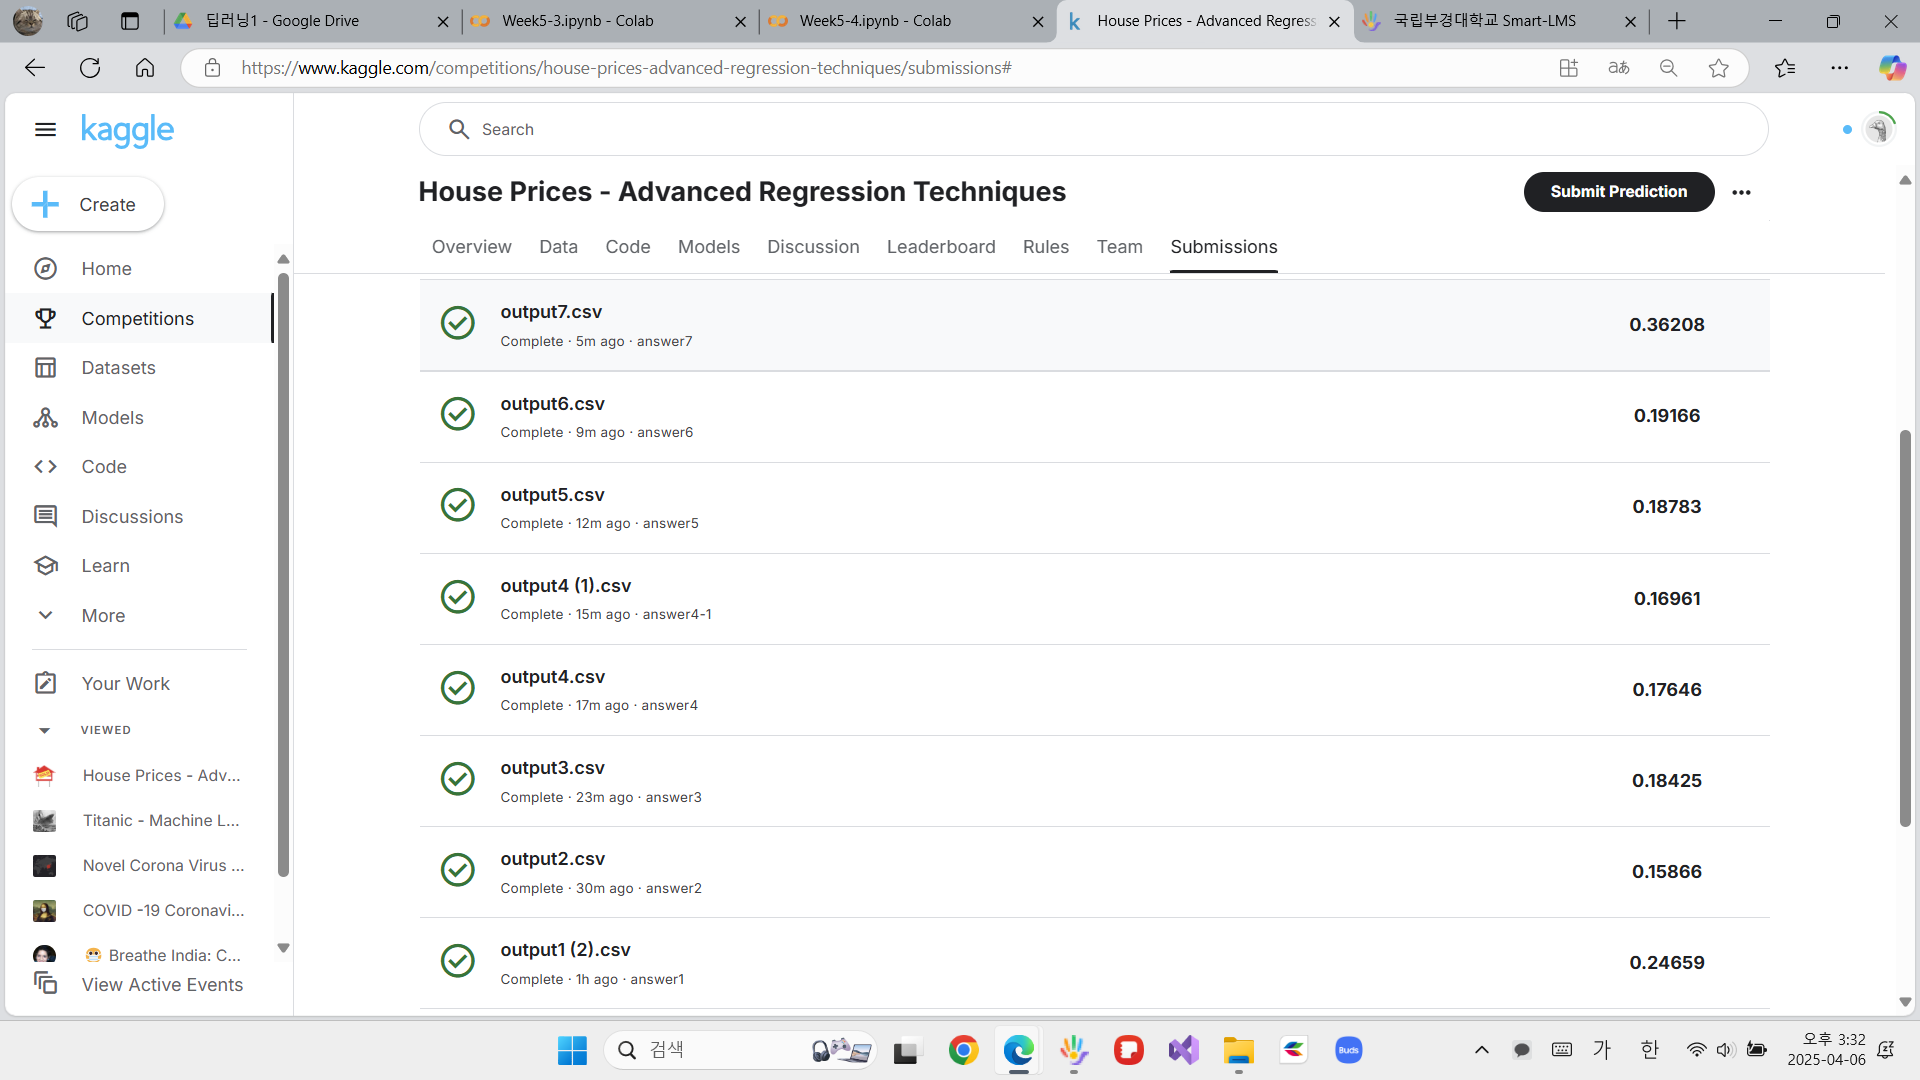